In [1]:
import pandas as pd

df = pd.read_excel("/mnt/e/Projects/Trajectory_Training/Data/multilabel/labels.xlsx")
df.head()

,Image_Name,center_velocity_field,focus_converging_field,focus_diverging_field,node_converging_field,node_diverging_field,saddle_field,shear_field,spiral_sink_field,spiral_source_field,improper_node_convergent_field,improper_node_divergent_field,Rotation,Divergent,Convergent
0,center_velocity_sample_1.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,center_velocity_sample_2.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,center_velocity_sample_3.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,center_velocity_sample_4.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,center_velocity_sample_5.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [2]:
labels = list(df.columns)[1:]
id2label = {id: label for id, label in enumerate(labels)}
print(id2label)
print(len(labels))
num_labels = 14

{0: 'center_velocity_field', 1: 'focus_converging_field', 2: 'focus_diverging_field', 3: 'node_converging_field', 4: 'node_diverging_field', 5: 'saddle_field', 6: 'shear_field', 7: 'spiral_sink_field', 8: 'spiral_source_field', 9: 'improper_node_convergent_field', 10: 'improper_node_divergent_field', 11: 'Rotation', 12: 'Divergent', 13: 'Convergent'}
14


In [3]:
import os
import pandas as pd
import tensorflow as tf
from transformers import AutoImageProcessor

# Load your labels
df = pd.read_excel("/mnt/e/Projects/Trajectory_Training/Data/multilabel/labels.xlsx")
labels = list(df.columns)[1:]
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in id2label.items()}

# Prepare image processor for vitl32_384
# model_id = "google/vit-large-patch32-384"
model_id = "google/vit-base-patch16-384"
processor = AutoImageProcessor.from_pretrained(model_id)

def preprocess_image(image_path, label_row):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the image as a 3-channel image
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Check if the image was successfully decoded
    if tf.shape(image)[-1] is None:
        raise ValueError(f"Failed to decode image: {image_path}")
    # Resize the image to (384, 384)
    image = tf.image.resize(image, (384, 384))
    # Transpose the image to match the shape (3, 384, 384)
    # Normalize the pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Convert the labels to a float32 tensor
    labels = tf.cast(label_row, tf.float32)
    return image, labels


# Dataset preparation
def create_dataset(df, root, batch_size=12):
    image_paths = [os.path.join(root, img) for img in df["Image_Name"]]
    labels = df.iloc[:, 1:].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Split the dataset
# from sklearn.model_selection import train_test_split
# train_df, val_df = train_test_split(df, test_size=0.3, random_state=1)

# train_dataset = create_dataset(train_df, "/mnt/e/Projects/Trajectory_Training/Data/multilabel/images", batch_size=12)
# val_dataset = create_dataset(val_df, "/mnt/e/Projects/Trajectory_Training/Data/multilabel/images", batch_size=12)


2024-12-25 19:53:33.280811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-25 19:53:33.280903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-25 19:53:33.407751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 19:53:33.636510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-25 19:53:35.016850: W tensorflow/compiler/tf2

In [4]:
# import tensorflow as tf
gpu_id = '0'  # or '0,1' for multiple GPUs

# Set GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices(physical_devices[int(gpu_id)], 'GPU')
    # Optionally, you can set memory growth to avoid allocating all GPU memory at once
    tf.config.experimental.set_memory_growth(physical_devices[int(gpu_id)], True)
else:
    print("No GPU devices found.")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


2024-12-25 19:53:40.746620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-25 19:53:40.746727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-25 19:53:40.755010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-25 19:53:40.755068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-25 19:53:40.755097: I external/local_xla/xla/stream_executor

In [5]:
# classes = {
#     0: "Center",
#     1: "Stable Focus (Convergent)",
#     2: "Unstable Focus (Divergent)",
#     3: "Stable Proper Node (Convergent)",
#     4: "Unstable Proper Node (Divergent)",
#     5: "Saddle Point",
#     6: "Degenerate Node (Zero Eigenvalues)",
#     7: "Stable Spiral (Spiral Sink)",
#     8: "Unstable Spiral (Spiral Source)",
#     9: "Stable Improper Node (Convergent)",
#     10: "Unstable Improper Node (Divergent)",
# }

classes = {
    0: "Center",
    1: "Stable Focus (Convergent)",
    2: "Unstable Focus (Divergent)",
    3: "Stable Proper Node (Convergent)",
    4: "Unstable Proper Node (Divergent)",
    5: "Saddle Point",
    6: "Degenerate Node (Zero Eigenvalues)",
    7: "Stable Spiral (Spiral Sink)",
    8: "Unstable Spiral (Spiral Source)",
    9: "Stable Improper Node (Convergent)",
    10: "Unstable Improper Node (Divergent)",
    11: "Rotation",
    12: "Divergent",
    13: "Convergent"
}

In [6]:
import numpy as np
import random, os

def seed_everything(seed = 1):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

# def data_augment(image):
#     seed_everything()
#     p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
#     p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
#     p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
#     p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
#     p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
#     # Flips
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    
#     if p_spatial > .75:
#         image = tf.image.transpose(image)
        
#     # Rotates
#     if p_rotate > .75:
#         image = tf.image.rot90(image, k = 3) # rotate 270º
#     elif p_rotate > .5:
#         image = tf.image.rot90(image, k = 2) # rotate 180º
#     elif p_rotate > .25:
#         image = tf.image.rot90(image, k = 1) # rotate 90º
        
#     # Pixel-level transforms
#     if p_pixel_1 >= .4:
#         image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
#     if p_pixel_2 >= .4:
#         image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
#     if p_pixel_3 >= .4:
#         image = tf.image.random_brightness(image, max_delta = .1)
        
#     return image


# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
#                                                           samplewise_center = True,
#                                                           samplewise_std_normalization = True,
#                                                           validation_split = 0.3,
#                                                           preprocessing_function = data_augment,
#                                                           )

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values for neural network compatibility
    samplewise_center=True,  # Center the data sample-wise (mean = 0)
    samplewise_std_normalization=True,  # Normalize the data sample-wise (std = 1)
    validation_split=0.3,  # Reserve 20% of the data for validation
    # preprocessing_function=data_augment,  # Custom preprocessing/augmentation function
    rotation_range=180,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.3,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.05,  # Apply shearing transformations
    zoom_range=0.3,  # Randomly zooming inside pictures
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='constant',  # Strategy used for filling in newly created pixels
    cval=1.0  # Constant value after rescaling; 1.0 corresponds to white
)


train_path = "/mnt/e/Projects/Trajectory_Training/Data/multilabel/images"

# Split the dataset
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.3, random_state=1)

batch_size = 16

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='Image_Name',   # Column in the DataFrame with the image file names
    y_col=list(df.columns[1:]),     # Column in the DataFrame with the multi-labels (must be one-hot encoded or multi-label format)
    target_size=(384, 384),
    batch_size=batch_size,
    seed=1,
    color_mode='rgb',
    shuffle=True,
    class_mode='raw'   # Use 'raw' to handle multi-label classification
    # subset='training'   # Subset is 'training'
)

valid_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_path,
    x_col='Image_Name',
    y_col=list(df.columns[1:]),
    target_size=(384, 384),
    batch_size=batch_size,
    seed=1,
    color_mode='rgb',
    shuffle=False,      # No need to shuffle validation data
    class_mode='raw'   # Use 'raw' for multi-label classification
    # subset='validation' # Subset is 'validation'
)

Found 2310 validated image filenames.
Found 990 validated image filenames.


Define the Multi-Label Model using TensorFlow:
--------------------

In [7]:
import tensorflow as tf
# Load the pre-trained vit-large-patch32-384 model from Hugging Face
# model_id = "google/vit-large-patch32-384"
# vit_model = TFViTModel.from_pretrained(model_id)
from vit_keras import vit,utils, visualize

# Set the image size and specify the ViT model (ViT-Large with patch size 32, input 384x384)
image_size = 384

# Load the pre-trained ViT model using vit_keras
vit_model = vit.vit_l32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,  # Load pretrained weights
    include_top=False,  # Exclude the classifier head since this is for multi-label classification
    pretrained_top=False,  # We will provide our own classification head
    classes=10  # Specify the number of classes in the pretrained head (irrelevant if include_top=False)
)

# Function to create a multi-label classification model using the pre-trained ViT
def create_multilabel_vit_model(num_classes):
    # Input layer for images (384x384x3 for RGB images)
    input_layer = tf.keras.layers.Input(shape=(384, 384, 3), name='input_image')
    # Pass the input through the ViT model (outputs a feature vector of shape (batch_size, 1024))
    vit_outputs = vit_model(input_layer, training=False)  # Output shape: (batch_size, 1024)
    # Add a fully connected layer for multi-label classification with sigmoid activation
    output_layer = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(vit_outputs)
    # Create and return the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Specify the number of labels/classes
num_classes = len(labels)  # You should replace this with the actual number of your labels

# Create the multi-label classification model
multilabel_vit_model = create_multilabel_vit_model(num_classes)

# Compile the model with binary crossentropy for multi-label classification
multilabel_vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='binary_crossentropy',  # Multi-label classification requires binary crossentropy
    metrics=['accuracy', tf.keras.metrics.AUC()]  # AUC is a useful metric for multi-label problems
)

# Print the summary of the model to check the architecture
multilabel_vit_model.summary()


/home/junfei/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-12-25 19:53:52.886900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-25 19:53:52.886997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 384, 384, 3)]     0         
                                                                 
 vit-l32 (Functional)        (None, 1024)              305607680 
                                                                 
 output (Dense)              (None, 14)                14350     
                                                                 
Total params: 305622030 (1.14 GB)
Trainable params: 305622030 (1.14 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
multilabel_vit_model.layers[1].summary()

Model: "vit-l32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 12, 12, 1024)      3146752   
                                                                 
 reshape (Reshape)           (None, 144, 1024)         0         
                                                                 
 class_token (ClassToken)    (None, 145, 1024)         1024      
                                                                 
 Transformer/posembed_input  (None, 145, 1024)         148480    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 145, 1024),       12596224  
  (TransformerBlock)          (None, 16, None, None)       

In [9]:
import tensorflow_addons as tfa
import tensorflow_ranking as tfr


def hamming_loss(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.5, tf.int32)  # Convert probabilities to binary predictions
    y_true = tf.cast(y_true, tf.int32)
    incorrect_labels = tf.reduce_sum(tf.abs(y_true - y_pred_binary))
    total_labels = tf.size(y_true)
    return tf.cast(incorrect_labels, tf.float32) / tf.cast(total_labels, tf.float32)


learning_rate = 5e-5

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

multilabel_vit_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), 
             tf.keras.metrics.AUC(name='auc', multi_label=True),
             'accuracy',
             tfr.keras.metrics.MeanAveragePrecisionMetric(name='map',topn=None),
            #  tfa.metrics.HammingLoss(name='hamming_loss',mode = 'multilabel',threshold=0.5),
            hamming_loss,
             tfa.metrics.F1Score(name='micro_f1',num_classes=num_labels, average='micro', threshold=0.5),
             ]
)

In [ ]:
# TRAINING
import warnings
warnings.filterwarnings("ignore")

import os
import datetime

log_dir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
# Add TensorBoard callback for logging
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq='batch',  # Log metrics after every batch
                                                      write_graph=True, 
                                                      write_images=True)


# Add callbacks for early stopping and model saving
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    # tf.keras.callbacks.EarlyStopping(monitor='val_hamming_loss', patience=20, restore_best_weights=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_micro_f1', patience=20, restore_best_weights=True, mode='max'),
    tf.keras.callbacks.ModelCheckpoint(filepath='/mnt/e/Projects/Trajectory_Training/Models/vitb16_384_multilabel.h5', save_best_only=True),
    tensorboard_callback  # Added TensorBoard callback
]

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

history = multilabel_vit_model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = 200,
          callbacks = callbacks)



In [ ]:
# SAVE MODEL
multilabel_vit_model.save("/mnt/e/Projects/Trajectory_Training/Models/vitb16_384_multilabel_final_f1micro09865.h5")

In [ ]:
# VALI for SAVE
result = multilabel_vit_model.evaluate(valid_gen)
print(f"Validation Accuracy: {result}")


In [10]:
from tensorflow.keras.models import load_model

# multilabel_vit_model=load_model("/mnt/e/Projects/Trajectory_Training/Models/vitb16_384_multilabel_final_hamming_loss00036.h5")
# Assuming multilabel_vit_model is already defined and compiled
multilabel_vit_model.load_weights("/mnt/e/Projects/Trajectory_Training/Models/vitb16_384_multilabel_final_f1micro09865.h5")


In [11]:
class_names = classes
class_names_abbrev = class_names

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from vit_keras import vit,layers
from matplotlib.font_manager import FontProperties

# Function to plot image with prediction results
def plot_image(i, predictions_array, img, threshold=0.5):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Display the image
    plt.imshow(img, cmap=plt.cm.binary)

    # Get top 4 predictions
    top_predicted_indices = np.argsort(predictions_array)[::-1][:4]  # Get top 4 predictions
    top_labels = [class_names[idx] for idx in top_predicted_indices]
    top_confidences = [predictions_array[idx] for idx in top_predicted_indices]

    return top_labels, top_confidences

    # # Prepare font properties
    # bold_font = FontProperties(weight='bold', size=12)
    # regular_font = FontProperties(weight='normal', size=12)
    
    # ax = plt.gca()

    # y_offset = -0.15  # move down for the next lines
    # # Display top predicted labels and their confidence percentages
    # # label_str = "Top 4 Predictions:\n"
    # ax.text(0.5, y_offset, "Top 4 Predictions:", 
    #     ha='center', va='top', 
    #     transform=ax.transAxes, 
    #     fontproperties=bold_font, 
    #     color='black')
    
    # y_offset -= 0.1  # move down for the next lines

    # for label, confidence in zip(top_labels, top_confidences):
    #     if confidence >= threshold:
    #         # label_str += f"{label}: {confidence:.2f}\n"  # Bold and black for confident predictions
    #         ax.text(0.5, y_offset, f"{label}: {confidence:.2f}", 
    #             ha='center', va='top', 
    #             transform=ax.transAxes,
    #             fontproperties=bold_font, 
    #             color='black')
    #     else:
    #         # label_str += f"{label}: {confidence:.2f}\n"  # Regular and grey for less confident predictions
    #         ax.text(0.5, y_offset, f"{label}: {confidence:.2f}", 
    #             ha='center', va='top', 
    #             transform=ax.transAxes,
    #             fontproperties=regular_font, 
    #             color='grey')
            
    # plt.xlabel(f"Top Predictions:\n{label_str}", fontsize=12, color='black')
    # plt.xlabel(f"{label_str}", fontsize=12, color='black')


def get_top_4(predictions_array):
    top_indices = np.argsort(predictions_array)[::-1][:4]
    top_labels = [class_names[idx] for idx in top_indices]
    top_confidences = [predictions_array[idx] for idx in top_indices]
    return top_labels, top_confidences



def plot_value_array(predictions_array):
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ytick_labels = ['0%', '20%', '40%', '60%', '80%', '100%']
    
    plt.grid(False)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(yticks, ytick_labels)

    # Plot the probabilities for each class
    thisplot = plt.bar(class_names_abbrev, predictions_array, color="#777777")
    plt.ylim([0, 1])

    # Color the bars based on a threshold (e.g., 0.5 as confidence threshold)
    threshold = 0.5
    for idx, bar in enumerate(thisplot):
        if predictions_array[idx] > threshold:
            bar.set_color('red')  # Confident predictions
        else:
            bar.set_color('blue')  # Less confident predictions


# Function to generate attention maps
def attention_map_view(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).

    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    img_height, img_width = model.input_shape[1], model.input_shape[2]
    grid_size = int(np.sqrt(model.layers[5].output_shape[0][-2] - 1))

    # Prepare the input
    X = vit.preprocess_inputs(cv2.resize(image, (img_height, img_width)))[np.newaxis, :]  # type: ignore

    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, layers.TransformerBlock)
    ]
    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
        ..., np.newaxis
    ]
    return reshaped, v, mask

In [13]:
# test_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test'
# test_path = '/mnt/e/Projects/Trajectory_Training/Data/LASER01tail8h'
test_path = '/mnt/e/Projects/Trajectory_Training/Data/LASER01tail12h'
# test_path = '/mnt/e/Projects/Trajectory_Training/Data/SPLASH01'
# test_path = '/mnt/e/Projects/Trajectory_Training/Data/SPLASH02'
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
#                                                           samplewise_center = True,
#                                                           samplewise_std_normalization = True,
#                                                           validation_split = 0.2,
#                                                           preprocessing_function = data_augment,
#                                                           )
# test_df = pd.read_excel("/mnt/e/Projects/Trajectory_Training/Data/multilabel/test/labels.xlsx")
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen  = test_datagen.flow_from_directory(
    # dataframe = test_df,
    directory = test_path,
    # x_col='Image_Name',
    # y_col=list(df.columns[1:]),
    target_size=(384, 384),
    batch_size = 1,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode=None   # Use 'raw' for multi-label classification
    # class_mode='categorical',
    )



Found 384 images belonging to 1 classes.


In [14]:
predicted_classes = multilabel_vit_model.predict(test_gen)
test_path_image = test_gen.filepaths

2024-12-25 19:55:35.783260: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


384/384 [==============================] - 71s 168ms/step


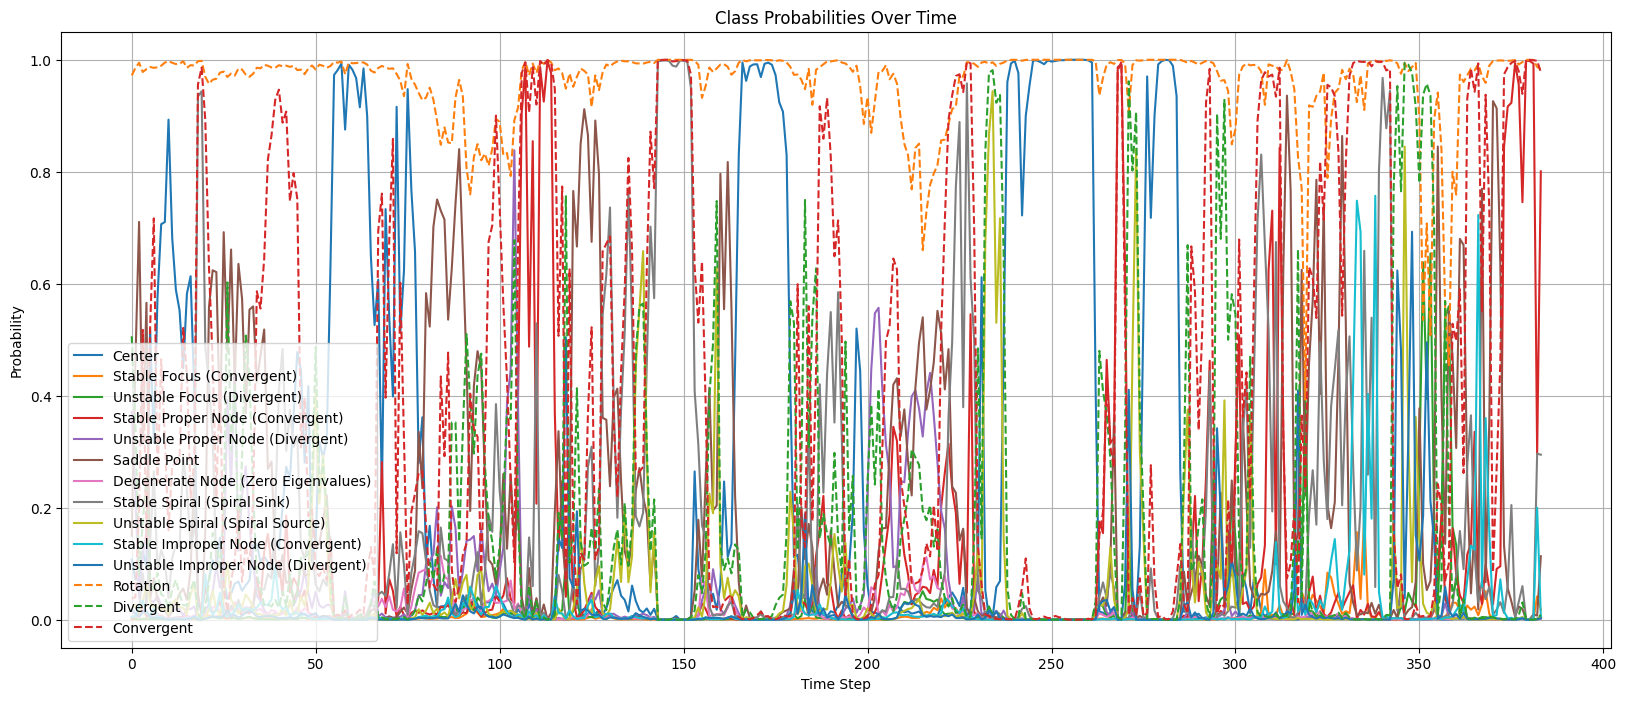

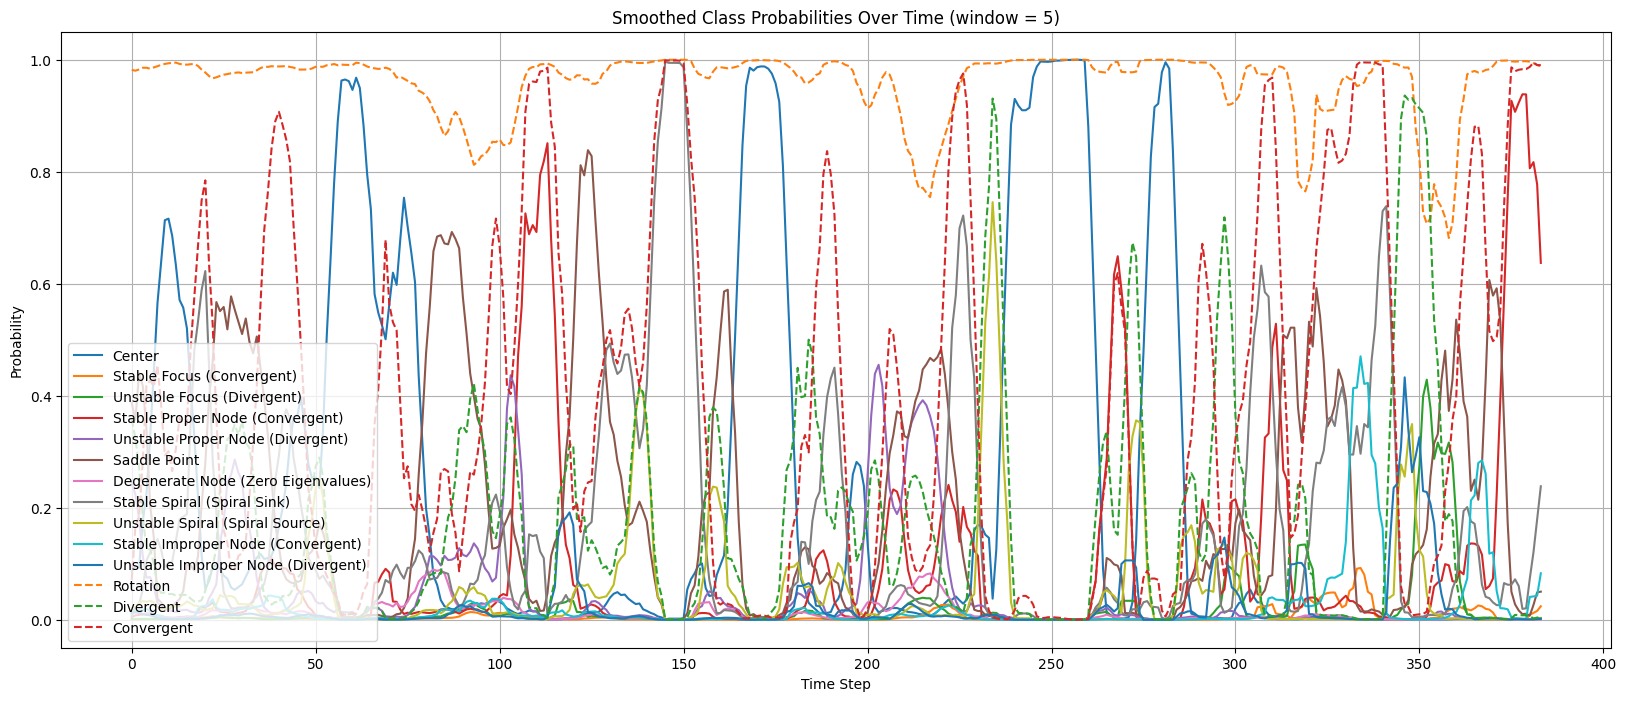

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
# X-axis: time steps
# class_labels = {
#     0: 'Center',
#     1: 'Focus Converging',
#     2: 'Focus Diverging',
#     3: 'Node Converging',
#     4: 'Node Diverging',
#     5: 'Saddle',
#     6: 'Shear',
#     7: 'Spiral Sink',
#     8: 'Spiral Source',
#     9: 'Rotation',
#     10: 'Divergent',
#     11: 'Convergent'
# } # id2label

class_labels = {
    0: "Center",
    1: "Stable Focus (Convergent)",
    2: "Unstable Focus (Divergent)",
    3: "Stable Proper Node (Convergent)",
    4: "Unstable Proper Node (Divergent)",
    5: "Saddle Point",
    6: "Degenerate Node (Zero Eigenvalues)",
    7: "Stable Spiral (Spiral Sink)",
    8: "Unstable Spiral (Spiral Source)",
    9: "Stable Improper Node (Convergent)",
    10: "Unstable Improper Node (Divergent)",
    11: "Rotation",
    12: "Divergent",
    13: "Convergent"
}

time_steps = np.arange(predicted_classes.shape[0])

# plt.figure(figsize=(12, 8))
plt.figure(figsize=(20, 8))

# Plot a line for each class
for class_idx in range(14):
       # Check for specific classes to use dashed lines
    if class_labels[class_idx] in ['Rotation', 'Divergent', 'Convergent']:
        plt.plot(time_steps, predicted_classes[:, class_idx], label=class_labels[class_idx], linestyle='--')
    else:
        plt.plot(time_steps, predicted_classes[:, class_idx], label=class_labels[class_idx], linestyle='-')
        
plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.title('Class Probabilities Over Time')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# Apply running mean (window size = 5) to smooth the probabilities
window_size = 5
smoothed_predictions = uniform_filter1d(predicted_classes, size=window_size, axis=0)

# plt.figure(figsize=(12, 8))
plt.figure(figsize=(20, 8))

# Plot a line for each class
for class_idx in range(14):
    # Check for specific classes to use dashed lines
    if class_labels[class_idx] in ['Rotation', 'Divergent', 'Convergent']:
        plt.plot(time_steps, smoothed_predictions[:, class_idx], label=class_labels[class_idx], linestyle='--')
    else:
        plt.plot(time_steps, smoothed_predictions[:, class_idx], label=class_labels[class_idx], linestyle='-')

plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.title(f'Smoothed Class Probabilities Over Time (window = {window_size})')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [16]:
# Function to print time steps with probabilities > 0.5
def print_high_prob_steps(predictions, threshold=0.5):
    for class_idx, class_name in class_labels.items():
        high_prob_indices = np.where(predictions[:, class_idx] > threshold)[0]
        if high_prob_indices.size > 0:
            print(f"Class '{class_name}': Time steps with probabilities > {threshold}: {high_prob_indices}")

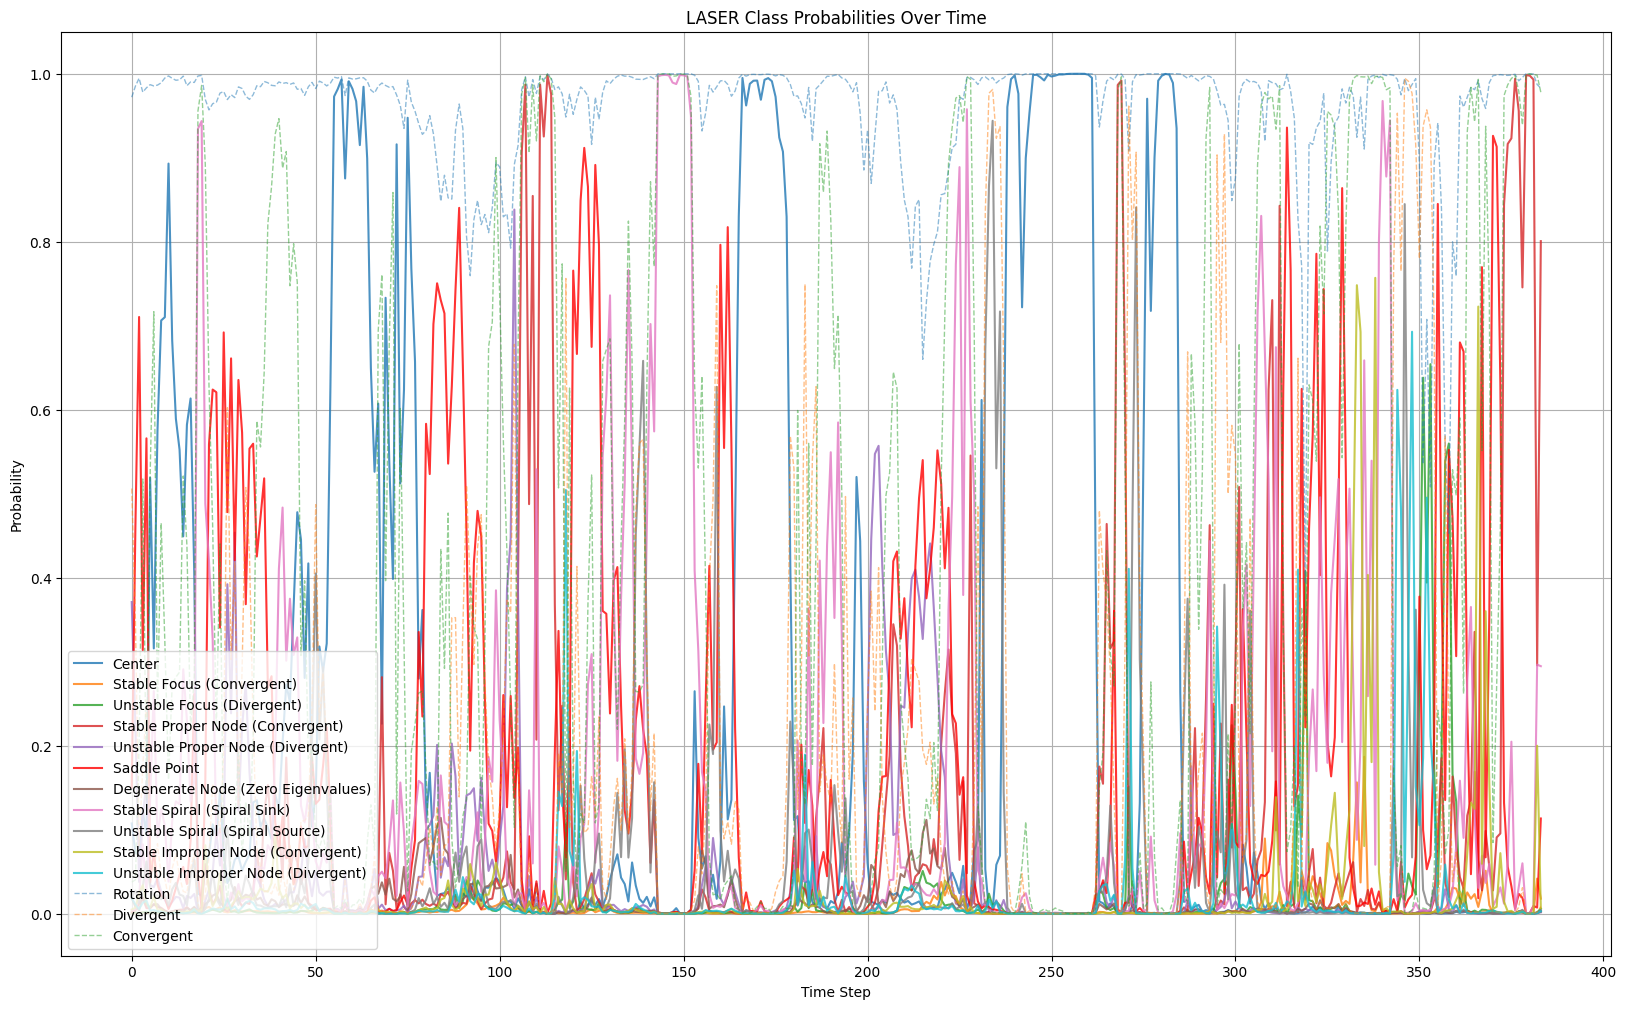

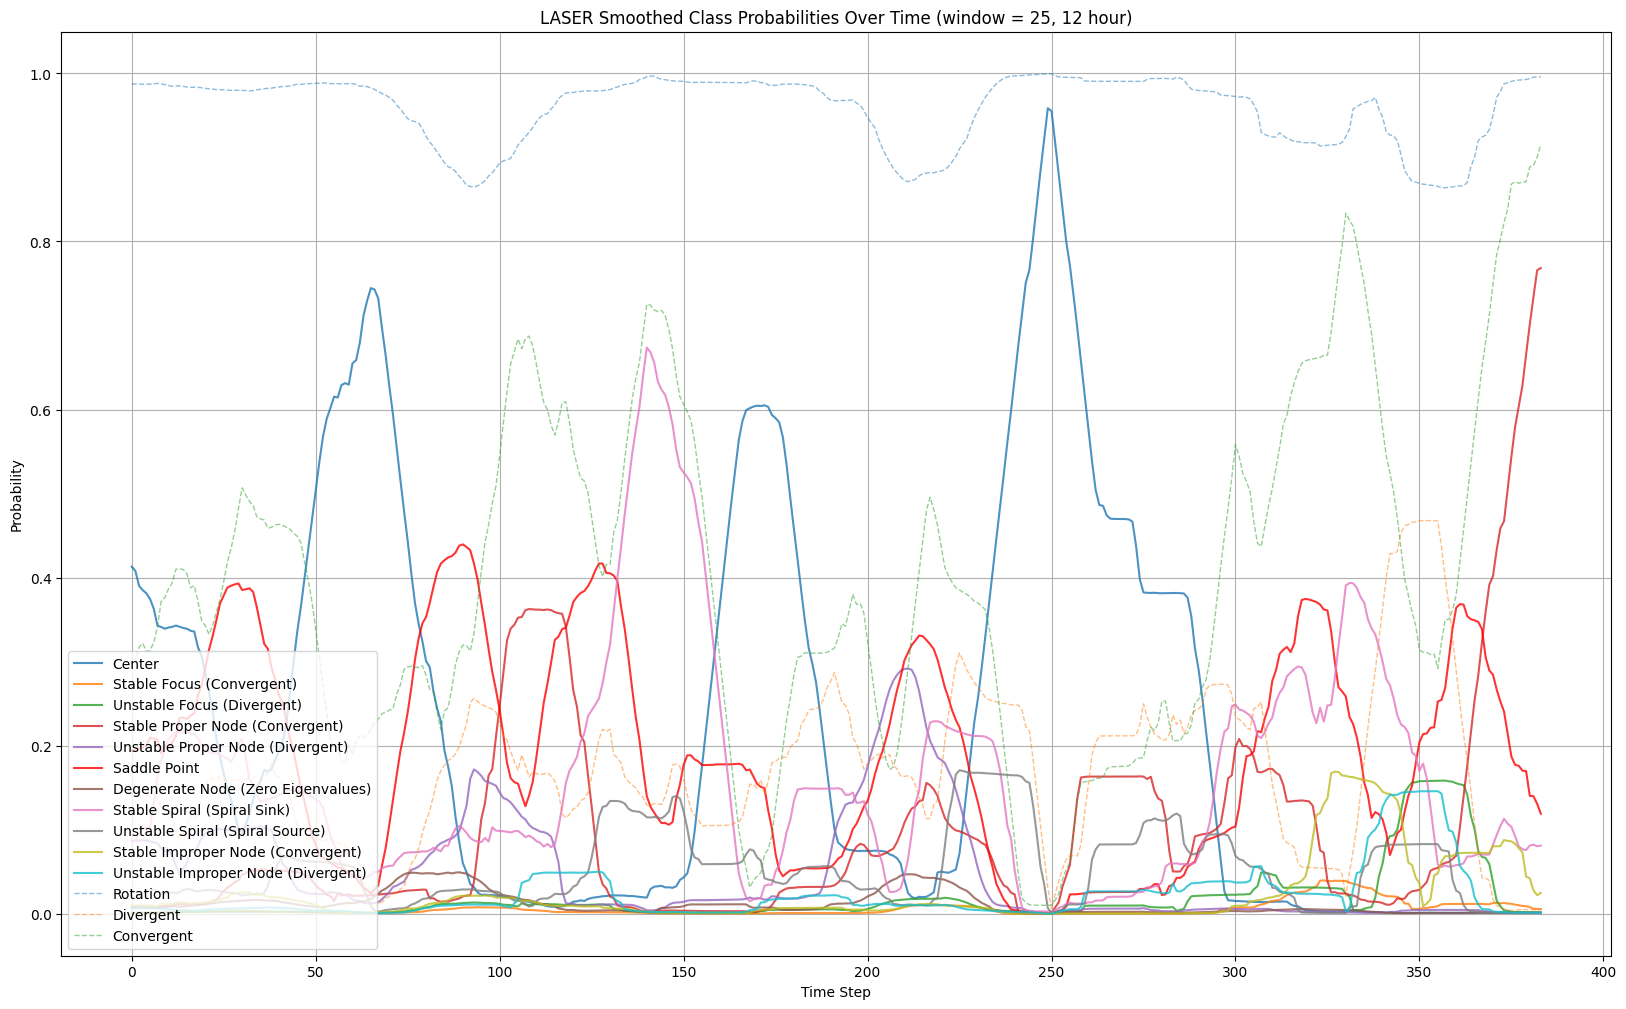

Class 'Center': Time steps with probabilities > 0.5: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262]
Class 'Stable Proper Node (Convergent)': Time steps with probabilities > 0.5: [374 375 376 377 378 379 380 381 382 383]
Class 'Stable Spiral (Spiral Sink)': Time steps with probabilities > 0.5: [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152]
Class 'Rotation': Time steps with probabilities > 0.5: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  8

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

class_labels = {
    0: "Center",
    1: "Stable Focus (Convergent)",
    2: "Unstable Focus (Divergent)",
    3: "Stable Proper Node (Convergent)",
    4: "Unstable Proper Node (Divergent)",
    5: "Saddle Point",
    6: "Degenerate Node (Zero Eigenvalues)",
    7: "Stable Spiral (Spiral Sink)",
    8: "Unstable Spiral (Spiral Source)",
    9: "Stable Improper Node (Convergent)",
    10: "Unstable Improper Node (Divergent)",
    11: "Rotation",
    12: "Divergent",
    13: "Convergent"
}

time_steps = np.arange(predicted_classes.shape[0])

# Original plot
plt.figure(figsize=(20, 12))

for class_idx in range(14):
    label = class_labels[class_idx]
    # Highlight saddle point
    if label == "Saddle Point":
        plt.plot(time_steps, predicted_classes[:, class_idx], label=label, linestyle='-', color='red', lw=1.5, alpha=0.8)
    elif label in ['Rotation', 'Divergent', 'Convergent']:
        plt.plot(time_steps, predicted_classes[:, class_idx], label=label, linestyle='--', lw=1, alpha=0.5)
    else:
        plt.plot(time_steps, predicted_classes[:, class_idx], label=label, linestyle='-', lw=1.5, alpha=0.8)

plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.title('LASER Class Probabilities Over Time')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Smoothed predictions
# window_size = 7 # 3 hour for LASER
# window_size = 13 # 6 hour for LASER
window_size = 25 # 12 hour for LASER
smoothed_predictions = uniform_filter1d(predicted_classes, size=window_size, axis=0)

plt.figure(figsize=(20, 12))

for class_idx in range(14):
    label = class_labels[class_idx]
    # Highlight saddle point
    if label == "Saddle Point":
        plt.plot(time_steps, smoothed_predictions[:, class_idx], label=label, linestyle='-', color='red', lw=1.5, alpha=0.8)
    elif label in ['Rotation', 'Divergent', 'Convergent']:
        plt.plot(time_steps, smoothed_predictions[:, class_idx], label=label, linestyle='--', lw=1, alpha=0.5)
    else:
        plt.plot(time_steps, smoothed_predictions[:, class_idx], label=label, linestyle='-', lw=1.5, alpha=0.8)

plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.title(f'LASER Smoothed Class Probabilities Over Time (window = {window_size}, 12 hour)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


print_high_prob_steps(smoothed_predictions)


In [ ]:
# Example Loop plt show

import matplotlib.gridspec as gridspec

threshold = 0.5

for i in range(0, len(predicted_classes), 100):
    image = utils.read(test_path_image[i], 384)
    reshaped, v, attention_map2 = attention_map_view(multilabel_vit_model.layers[1], image)

    attention_image2 = attention_map2.mean(axis=-1)
    attention_image2 = (attention_image2 - np.min(attention_image2)) / (np.max(attention_image2) - np.min(attention_image2))

    heatmap2 = cv2.applyColorMap((attention_image2 * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlayed_image2 = cv2.addWeighted(
        cv2.cvtColor(cv2.cvtColor(np.uint8(image), cv2.COLOR_RGB2GRAY), cv2.COLOR_RGB2BGR),
        0.7, heatmap2, 0.3, 0
    )

    # Get top predictions
    top_labels, top_confidences = get_top_4(predicted_classes[i])
    left_labels = top_labels[:2]
    left_confs = top_confidences[:2]
    right_labels = top_labels[2:]
    right_confs = top_confidences[2:]

    # Font properties
    bold_font = FontProperties(weight='bold', size=10)
    regular_font = FontProperties(weight='normal', size=10)

    # Create a GridSpec layout with constrained_layout=True
    fig = plt.figure(figsize=(10, 6), constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[4, 0.8]) 

    # Top row subplots
    ax_img = fig.add_subplot(gs[0,0])
    ax_attn = fig.add_subplot(gs[0,1])

    fig.suptitle("Prediction and Attention Visualization", fontsize=14, fontweight='bold')

    # Display the original image
    ax_img.imshow(image, cmap='binary')
    ax_img.set_title(f"Time Step: {i+1}", fontsize=12)
    ax_img.axis('off')  # or 'off' if you prefer no axes

    # Display attention overlay
    im = ax_attn.imshow(cv2.cvtColor(overlayed_image2, cv2.COLOR_BGR2RGB), cmap='jet', vmin=0, vmax=1)
    ax_attn.set_title("Attention Visualization", fontsize=12)
    ax_attn.axis('off')

    # Add colorbar to the right subplot
    cbar = fig.colorbar(im, ax=ax_attn, fraction=0.046, pad=0.04)
    cbar.set_label('Attention Weight', rotation=270, labelpad=15, fontsize=10)

    # Bottom row for predictions (single subplot spanning both columns)
    ax_text = fig.add_subplot(gs[1,:])
    ax_text.axis('off')

    # Write "Top 4 Predictions:" in the middle
    ax_text.text(0.5, 1, "Top 4 Predictions:", ha='center', va='center', fontproperties=bold_font, color='black',fontsize=12)

    # Place the four predictions in one line:
    # Example spacing: left two predictions centered around 0.4 and 0.5, right two around 0.5 and 0.6
    # Adjust as needed for desired spacing
    # Positions for the top row (2 predictions)
    x_positions_top = [0.27, 0.75]    # Adjust as needed
    y_top = 0.7                     # Vertical position of the top row

    # Positions for the bottom row (2 predictions)
    x_positions_bottom = [0.27, 0.75] # Adjust as needed
    y_bottom = 0.3                 # Vertical position of the bottom row

    # Plot the top row predictions
    for (label, conf), x_pos in zip(zip(top_labels[:2], top_confidences[:2]), x_positions_top):
        color = 'black' if conf >= threshold else 'grey'
        fontprop = bold_font if conf >= threshold else regular_font
        ax_text.text(x_pos, y_top, f"{label}: {conf:.2f}",
                    ha='center', va='center',
                    fontproperties=fontprop, color=color, fontsize=11)

    # Plot the bottom row predictions
    for (label, conf), x_pos in zip(zip(top_labels[2:], top_confidences[2:]), x_positions_bottom):
        color = 'black' if conf >= threshold else 'grey'
        fontprop = bold_font if conf >= threshold else regular_font
        ax_text.text(x_pos, y_bottom, f"{label}: {conf:.2f}",
                    ha='center', va='center',
                    fontproperties=fontprop, color=color, fontsize=11)
    plt.show()

In [23]:
# Save images
# Define the output directory
# output_dir = "/mnt/e/Projects/Trajectory_Training/Data/outputs/SPLASH02-f1/"
output_dir = "/mnt/e/Projects/Trajectory_Training/Data/outputs/LASER/"
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

# Example Loop
import matplotlib.gridspec as gridspec

threshold = 0.5

for i in range(0, len(predicted_classes)):
    image = utils.read(test_path_image[i], 384)
    reshaped, v, attention_map2 = attention_map_view(multilabel_vit_model.layers[1], image)

    attention_image2 = attention_map2.mean(axis=-1)
    attention_image2 = (attention_image2 - np.min(attention_image2)) / (np.max(attention_image2) - np.min(attention_image2))

    heatmap2 = cv2.applyColorMap((attention_image2 * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlayed_image2 = cv2.addWeighted(
        cv2.cvtColor(cv2.cvtColor(np.uint8(image), cv2.COLOR_RGB2GRAY), cv2.COLOR_RGB2BGR),
        0.7, heatmap2, 0.3, 0
    )

    # Get top predictions
    top_labels, top_confidences = get_top_4(predicted_classes[i])
    left_labels = top_labels[:2]
    left_confs = top_confidences[:2]
    right_labels = top_labels[2:]
    right_confs = top_confidences[2:]

    # Font properties
    bold_font = FontProperties(weight='bold', size=10)
    regular_font = FontProperties(weight='normal', size=10)

    # Create a GridSpec layout with constrained_layout=True
    fig = plt.figure(figsize=(10, 6), constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[4, 0.8]) 

    # Top row subplots
    ax_img = fig.add_subplot(gs[0,0])
    ax_attn = fig.add_subplot(gs[0,1])

    fig.suptitle("Prediction and Attention Visualization", fontsize=14, fontweight='bold')

    # Display the original image
    ax_img.imshow(image, cmap='binary')
    ax_img.set_title(f"Time Step: {i+1}", fontsize=12)
    ax_img.axis('off')  # or 'off' if you prefer no axes

    # Display attention overlay
    im = ax_attn.imshow(cv2.cvtColor(overlayed_image2, cv2.COLOR_BGR2RGB), cmap='jet', vmin=0, vmax=1)
    ax_attn.set_title("Attention Visualization", fontsize=12)
    ax_attn.axis('off')

    # Add colorbar to the right subplot
    cbar = fig.colorbar(im, ax=ax_attn, fraction=0.046, pad=0.04)
    cbar.set_label('Attention Weight', rotation=270, labelpad=15, fontsize=10)

    # Bottom row for predictions (single subplot spanning both columns)
    ax_text = fig.add_subplot(gs[1,:])
    ax_text.axis('off')

    # Write "Top 4 Predictions:" in the middle
    ax_text.text(0.5, 1, "Top 4 Predictions:", ha='center', va='center', fontproperties=bold_font, color='black',fontsize=12)

    # Place the four predictions in one line:
    # Example spacing: left two predictions centered around 0.4 and 0.5, right two around 0.5 and 0.6
    # Adjust as needed for desired spacing
    # Positions for the top row (2 predictions)
    x_positions_top = [0.27, 0.75]    # Adjust as needed
    y_top = 0.7                     # Vertical position of the top row

    # Positions for the bottom row (2 predictions)
    x_positions_bottom = [0.27, 0.75] # Adjust as needed
    y_bottom = 0.3                 # Vertical position of the bottom row

    # Plot the top row predictions
    for (label, conf), x_pos in zip(zip(top_labels[:2], top_confidences[:2]), x_positions_top):
        color = 'black' if conf >= threshold else 'grey'
        fontprop = bold_font if conf >= threshold else regular_font
        ax_text.text(x_pos, y_top, f"{label}: {conf:.2f}",
                    ha='center', va='center',
                    fontproperties=fontprop, color=color, fontsize=11)

    # Plot the bottom row predictions
    for (label, conf), x_pos in zip(zip(top_labels[2:], top_confidences[2:]), x_positions_bottom):
        color = 'black' if conf >= threshold else 'grey'
        fontprop = bold_font if conf >= threshold else regular_font
        ax_text.text(x_pos, y_bottom, f"{label}: {conf:.2f}",
                    ha='center', va='center',
                    fontproperties=fontprop, color=color, fontsize=11)
        
    # plt.show()


    # Save the figure
    # Extract the filename from the input image path
    input_image_path = test_path_image[i]  # Assuming `test_path_image` contains the image paths
    filename = os.path.basename(input_image_path)  # Extract just the filename (e.g., "image_01.png")
    filename_without_extension = os.path.splitext(filename)[0]  # Get the filename without the extension

    output_figure_path = os.path.join(output_dir, f"{filename_without_extension}_figure.png")
    plt.savefig(output_figure_path,bbox_inches='tight',dpi=300)
    # Close the figure to free up memory
    plt.close()

1/1 [==============================] - 4s 4s/step


In [ ]:
multilabel_vit_model.layers[1].layers

In [ ]:
multilabel_vit_model.summary()

In [ ]:
multilabel_vit_model.layers[1].layers[0]

In [ ]:
# model.eval()

# # prepare image for the model
# pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# # forward pass
# with torch.no_grad():
#   outputs = model(pixel_values)
#   logits = outputs.logits

In [ ]:
# # turn into probabilities by applying sigmoid
# sigmoid = torch.nn.Sigmoid()
# probs = sigmoid(logits.squeeze().cpu())

# # select the probabilities > a certain threshold (e.g. 50%) as predicted
# predictions = np.zeros(probs.shape)
# predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
# print(predicted_labels)

In [ ]:
# image = Image.open("/mnt/e/Projects/Trajectory_Training/Data/multilabel/test/image_76.png")
# image

In [ ]:
# model.eval()

# # prepare image for the model
# pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# # forward pass
# with torch.no_grad():
#   outputs = model(pixel_values)
#   logits = outputs.logits

# # turn into probabilities by applying sigmoid
# sigmoid = torch.nn.Sigmoid()
# probs = sigmoid(logits.squeeze().cpu())

# # select the probabilities > a certain threshold (e.g. 50%) as predicted
# predictions = np.zeros(probs.shape)
# predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
# print(predicted_labels)

In [ ]:
# image = Image.open("/mnt/e/Projects/Trajectory_Training/Data/multilabel/test/image_141.png")
# image

In [ ]:
# model.eval()

# # prepare image for the model
# pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# # forward pass
# with torch.no_grad():
#   outputs = model(pixel_values)
#   logits = outputs.logits

# # turn into probabilities by applying sigmoid
# sigmoid = torch.nn.Sigmoid()
# probs = sigmoid(logits.squeeze().cpu())

# # select the probabilities > a certain threshold (e.g. 50%) as predicted
# predictions = np.zeros(probs.shape)
# predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
# print(predicted_labels)

In [ ]:
# image = Image.open("/mnt/e/Projects/Trajectory_Training/Data/multilabel/test/image_171.png")
# image

In [ ]:
# model.eval()

# # prepare image for the model
# pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# # forward pass
# with torch.no_grad():
#   outputs = model(pixel_values)
#   logits = outputs.logits

# # turn into probabilities by applying sigmoid
# sigmoid = torch.nn.Sigmoid()
# probs = sigmoid(logits.squeeze().cpu())

# # select the probabilities > a certain threshold (e.g. 50%) as predicted
# predictions = np.zeros(probs.shape)
# predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
# print(predicted_labels)

In [ ]:
# image = Image.open("/mnt/e/Projects/Trajectory_Training/Data/multilabel/test/image_190.png")
# image

In [ ]:
# model.eval()

# # prepare image for the model
# pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# # forward pass
# with torch.no_grad():
#   outputs = model(pixel_values)
#   logits = outputs.logits

# # turn into probabilities by applying sigmoid
# sigmoid = torch.nn.Sigmoid()
# probs = sigmoid(logits.squeeze().cpu())

# # select the probabilities > a certain threshold (e.g. 50%) as predicted
# predictions = np.zeros(probs.shape)
# predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
# print(predicted_labels)

In [ ]:
# image = Image.open("/mnt/e/Projects/Trajectory_Training/Data/multilabel/test/image_209.png")
# image

In [ ]:
# model.eval()

# # prepare image for the model
# pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# # forward pass
# with torch.no_grad():
#   outputs = model(pixel_values)
#   logits = outputs.logits

# # turn into probabilities by applying sigmoid
# sigmoid = torch.nn.Sigmoid()
# probs = sigmoid(logits.squeeze().cpu())

# # select the probabilities > a certain threshold (e.g. 50%) as predicted
# predictions = np.zeros(probs.shape)
# predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
# print(predicted_labels)